#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 23
**CH 23 IMPORT DEMAND AND PRODUCTION**

using the asia-industry dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import pyfixest as pf
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/asia-industry/clean/"
data_out = dirname + "da_case_studies/ch23-import-demand-and-production/"
output = dirname + "da_case_studies/ch23-import-demand-and-production/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

# Set custom color scheme for plots
sns.set_theme(rc=da_theme, palette=color)

In [4]:
# import data
raw = pd.read_csv(data_in + "asia-industry_tidy.csv")
# raw = pd.read_csv("https://osf.io/3kd4c/download")


In [5]:
data = raw.loc[lambda x: x["year"] >= 1998]


In [6]:
data = data.drop(data.loc[lambda x: (x["year"] == 1998) & (x["month"] == 1)].index)
data = data.drop(data.loc[lambda x: (x["year"] == 2018) & (x["month"] > 4)].index)


In [7]:
data.groupby("countrycode").agg(
    mean=("ind_prod_const", "mean"),
    std_dev=("ind_prod_const", "first"),
    freq=("ind_prod_const", "count"),
).dropna().reset_index().sort_values(by="countrycode")


,countrycode,mean,std_dev,freq
0,CHN,2.046815e+11,4.956969e+10,243
1,IDN,2.729169e+10,1.591749e+10,243
2,MYS,8.150858e+09,4.526050e+09,243
3,PHL,7.193672e+09,6.599710e+09,243
4,SGP,4.840317e+09,2.324321e+09,243
5,THA,9.791123e+09,5.602920e+09,243
6,TWN,1.171419e+10,6.744322e+09,242
7,USA,2.640678e+11,2.344603e+11,243


In [8]:
# feature engineering


In [9]:
data = data.merge(
    data.groupby("time")
    .apply(
        lambda x: max(np.where(x["countrycode"] == "USA", x["ind_prod_const_sa"], 0))
    )
    .reset_index()
    .rename(columns={0: "usa_ip_sa"}),
    on="time",
)


In [10]:
data = data.merge(
    data.groupby("time")
    .apply(
        lambda x: max(np.where(x["countrycode"] == "CHN", x["ind_prod_const_sa"], 0))
    )
    .reset_index()
    .rename(columns={0: "chn_ip_sa"}),
    on="time",
)


In [11]:
data["ln_ip"] = np.log(data["ind_prod_const_sa"] + 1)
data["ln_usa_ip"] = np.log(data["usa_ip_sa"] + 1)
data["ln_chn_ip"] = np.log(data["chn_ip_sa"] + 1)
data["ln_usa_imports"] = np.log(data["usa_imp_sa"] + 1)
data["ln_er_usd"] = np.log(data["exchnage_rate_vs_usd"] + 1)


In [12]:
data = data.dropna(subset=["ln_ip"])


In [13]:
data = data.loc[
    lambda x: (x["countrycode"] == "MYS")
    | (x["countrycode"] == "PHL")
    | (x["countrycode"] == "SGP")
    | (x["countrycode"] == "THA")
]


In [14]:
data.groupby("countrycode")["country"].count()


countrycode
MYS    243
PHL    243
SGP    243
THA    243
Name: country, dtype: int64

In [15]:
# panel setup
# encode country , gen(cc)
# sort cc time
# tsset cc time


In [16]:
data["cc"] = data["countrycode"].astype("category")


In [17]:
# lagged variables
work = data.sort_values(by=["cc", "time"])


In [18]:
work["dln_ip"] = work.groupby("cc")["ln_ip"].transform("diff")
work["dln_usa_ip"] = work.groupby("cc")["ln_usa_ip"].transform("diff")
work["dln_chn_ip"] = work.groupby("cc")["ln_chn_ip"].transform("diff")
work["dln_usa_imports"] = work.groupby("cc")["ln_usa_imports"].transform("diff")
work["ddln_usa_imports"] = work.groupby("cc")["dln_usa_imports"].transform("diff")
work["dln_er_usd"] = work.groupby("cc")["ln_er_usd"].transform("diff")

In [19]:
work.groupby("countrycode").agg(mean=("dln_ip", np.nanmean))


,mean
countrycode,
MYS,0.003534
PHL,0.002520
SGP,0.004417
THA,0.003536


In [20]:
# create time variables
work["date"] = (work["year"].astype(str) + "-" + data["month"].astype(str)).apply(
    lambda x: dt.strptime(x, "%Y-%m")
)


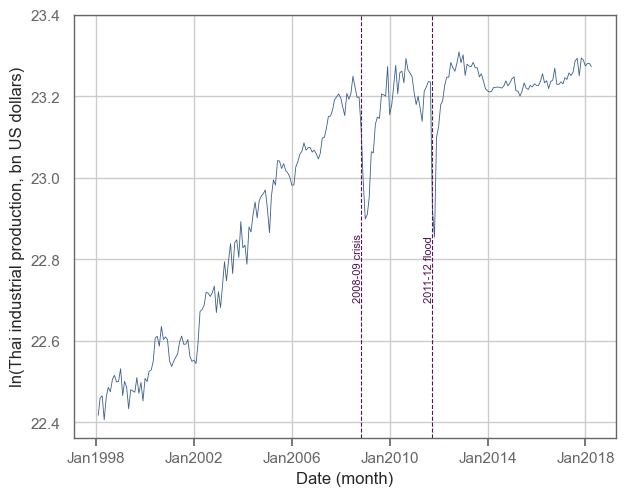

In [21]:
thai_data = work.loc[work["country"] == "Thailand"].reset_index()
fig, ax = plt.subplots()

# Plot the line chart
sns.lineplot(data=thai_data, x="date", y="ln_ip", ax=ax, linewidth=0.6)

# Add vertical lines and annotations
ax.axvline(
    x=dt.strptime("2008-11-01", "%Y-%m-%d"),
    color=color[2],
    linestyle="--",
    linewidth=0.8,
)
ax.text(
    dt.strptime("2008-07-01", "%Y-%m-%d"),
    22.7,
    "2008-09 crisis",
    color=color[2],
    fontsize=8,
    rotation=90,
)

ax.axvline(
    x=dt.strptime("2011-10-01", "%Y-%m-%d"),
    color=color[2],
    linestyle="--",
    linewidth=0.8,
)
ax.text(
    dt.strptime("2011-06-01", "%Y-%m-%d"),
    22.7,
    "2011-12 flood",
    color=color[2],
    fontsize=8,
    rotation=90,
)

ax.set_xlabel("Date (month)", fontsize=12)
ax.set_ylabel("ln(Thai industrial production, bn US dollars)", fontsize=12)


ax.set_yticks([22.4, 22.6, 22.8, 23.0, 23.2, 23.4])
x_ticks = [
    "1998-01-01",
    "2002-01-01",
    "2006-01-01",
    "2010-01-01",
    "2014-01-01",
    "2018-01-01",
]
x_tick_labels = [dt.strptime(date, "%Y-%m-%d").strftime("%b%Y") for date in x_ticks]
ax.set_xticks([pd.Timestamp(date) for date in x_ticks])
ax.set_xticklabels(x_tick_labels)

plt.show()

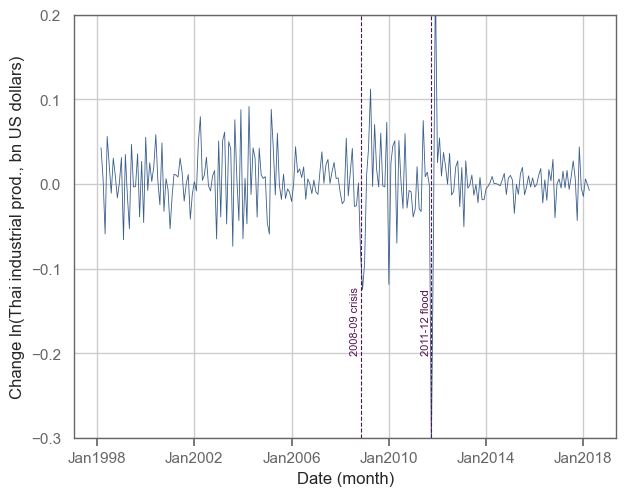

In [22]:
fig, ax = plt.subplots()

# Plot the line chart
sns.lineplot(data=thai_data, x="date", y="dln_ip", ax=ax, linewidth=0.6)

ax.set_ylim(-0.3, 0.2)
ax.set_yticks([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2])

# Add vertical lines and annotations
ax.axvline(x=dt.strptime("2008-11-01", "%Y-%m-%d"), color=color[2], linestyle="--", linewidth=0.8)
ax.text(dt.strptime("2008-06-01", "%Y-%m-%d"), -0.2, "2008-09 crisis", color=color[2], fontsize=8, rotation=90)

ax.axvline(x=dt.strptime("2011-10-01", "%Y-%m-%d"), color=color[2], linestyle="--", linewidth=0.8)
ax.text(dt.strptime("2011-05-01", "%Y-%m-%d"), -0.2, "2011-12 flood", color=color[2], fontsize=8, rotation=90)

ax.set_xlabel("Date (month)", fontsize=12)
ax.set_ylabel("Change ln(Thai industrial prod., bn US dollars)", fontsize=12)


x_ticks = [
    "1998-01-01",
    "2002-01-01",
    "2006-01-01",
    "2010-01-01",
    "2014-01-01",
    "2018-01-01",
]
x_tick_labels = [dt.strptime(date, "%Y-%m-%d").strftime("%b%Y") for date in x_ticks]
ax.set_xticks([pd.Timestamp(date) for date in x_ticks])
ax.set_xticklabels(x_tick_labels)
add_margin(ax, x=0.005, y=0)

plt.show()


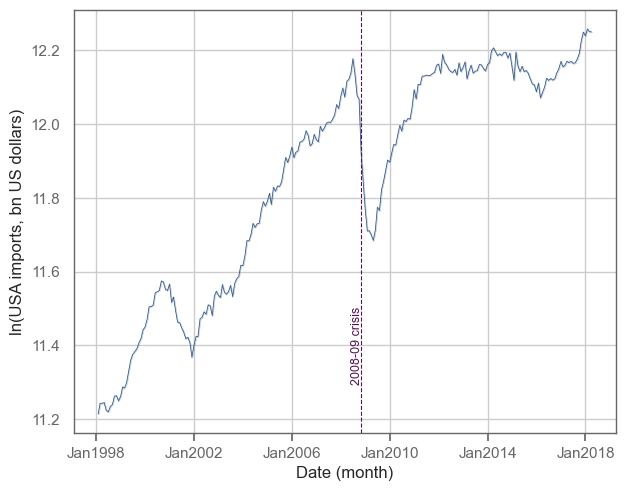

In [23]:
fig, ax = plt.subplots()


sns.lineplot(data=work.reset_index(), x="date", y="ln_usa_imports", ax=ax, linewidth=0.6)

ax.set_xlabel("Date (month)", fontsize=12)
ax.set_ylabel("ln(USA imports, bn US dollars)", fontsize=12)


ax.set_yticks([11.2, 11.4, 11.6, 11.8, 12.0, 12.2])

# Set x-axis ticks and format
x_ticks = [
    "1998-01-01",
    "2002-01-01",
    "2006-01-01",
    "2010-01-01",
    "2014-01-01",
    "2018-01-01",
]
x_tick_labels = [dt.strptime(date, "%Y-%m-%d").strftime("%b%Y") for date in x_ticks]
ax.set_xticks([pd.Timestamp(date) for date in x_ticks])
ax.set_xticklabels(x_tick_labels)

crisis_date = pd.Timestamp("2008-11-01")
ax.axvline(x=crisis_date, color=color[2], linestyle="--", linewidth=0.8)

ax.text(
    pd.Timestamp("2008-06-01"),
    11.4,
    "2008-09 crisis",
    color=color[2],
    fontsize=9,
    rotation=90,
    verticalalignment="center",
)

plt.show()


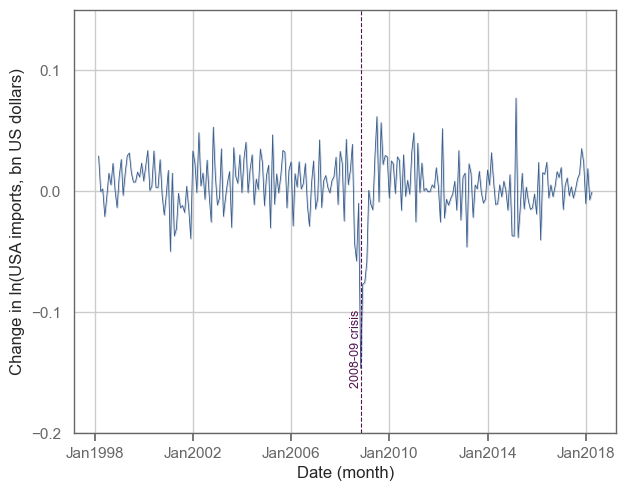

In [24]:
fig, ax = plt.subplots()

# Plot the line chart
sns.lineplot(
    data=work.reset_index(), x="date", y="dln_usa_imports", ax=ax, linewidth=0.6
)

ax.set_ylim(-0.2, 0.15)
ax.set_yticks(np.arange(-0.2, 0.16, 0.1))
ax.margins(y=0.01)

x_ticks = [
    "1998-01-01",
    "2002-01-01",
    "2006-01-01",
    "2010-01-01",
    "2014-01-01",
    "2018-01-01",
]
x_tick_labels = [dt.strptime(date, "%Y-%m-%d").strftime("%b%Y") for date in x_ticks]
ax.set_xticks([pd.Timestamp(date) for date in x_ticks])
ax.set_xticklabels(x_tick_labels)

ax.axvline(x=pd.Timestamp("2008-11-01"), color=color[2], linestyle="--", linewidth=0.8)
ax.text(
    pd.Timestamp("2008-06-01"),
    -0.13,
    "2008-09 crisis",
    color=color[2],
    fontsize=9,
    rotation=90,
    verticalalignment="center",
)

ax.set_xlabel("Date (month)", fontsize=12)
ax.set_ylabel("Change in ln(USA imports, bn US dollars)", fontsize=12)
plt.show()

In [25]:
# REGRESSIONS

# Serial correlation matters because it may lead to biased standard error estimates.
# We recommended two ways to address this problem: estimate Newey–West standard errors
# or include the lag of the dependent variable in the regression. (Used here.)


In [26]:
lags_usa = " + ".join(["dln_usa_imports.shift({i})".format(i=i) for i in range(0, 5)])
lags_ip = " + ".join(["dln_ip.shift({i})".format(i=i) for i in range(1, 3)])

thai_formula = "dln_ip ~ " + lags_usa + " + " + lags_ip


In [27]:
pf.feols(thai_formula, work.loc[lambda x: x["countrycode"] == "THA"]).summary()


###

Estimation:  OLS
Dep. var.: dln_ip, Fixed effects: 0
Inference:  iid
Observations:  238

| Coefficient              |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept                |      0.002 |        0.003 |     0.849 |      0.397 | -0.003 |   0.008 |
| dln_usa_imports.shift(0) |      0.343 |        0.121 |     2.846 |      0.005 |  0.106 |   0.580 |
| dln_usa_imports.shift(1) |      0.280 |        0.122 |     2.301 |      0.022 |  0.040 |   0.521 |
| dln_usa_imports.shift(2) |      0.185 |        0.115 |     1.603 |      0.110 | -0.042 |   0.412 |
| dln_usa_imports.shift(3) |     -0.123 |        0.120 |    -1.020 |      0.309 | -0.359 |   0.114 |
| dln_usa_imports.shift(4) |     -0.194 |        0.120 |    -1.620 |      0.107 | -0.430 |   0.042 |
| dln_ip.shift(1)          |     -0.138 |        0.065 |    -2.142 |      0.033 | -0.265 |  -0.011

In [28]:
# long-term coeff, lagged dy, countries separately
lags_usa = " + ".join(["ddln_usa_imports.shift({i})".format(i=i) for i in range(0, 4)])
lt_formula = "dln_ip ~ dln_usa_imports.shift(4) + " + lags_usa + "+ dln_ip.shift(1)"

In [29]:
countries = ["THA", "MYS", "PHL", "SGP"]
reg_results = []

for country in countries:
    reg_results.append(
        pf.feols(lt_formula, work.loc[lambda x: x["countrycode"] == country])
    )

In [30]:
# long-term coeff, lagged dy, countries pooled
lt_formula_pooled = (
    "dln_ip ~ dln_usa_imports.shift(4) + " + lags_usa + " + dln_ip.shift(1) + cc"
)
pooled_reg_lt = pf.feols(lt_formula_pooled, work)

### Table 23.1 US imports and industrial production in Thailand and three other countries

In [31]:
pf.etable(
    reg_results + [pooled_reg_lt],
    model_heads=["Thailand", "Malaysia", "Philippines", "Singapore", "Pooled"],
    head_order="h",
    labels={
        "Intercept": "Constant",
        "dln_usa_imports.shift(4)": "USA imports log change, cumulative coeff.",
        "dln_ip.shift(1)": "Industrial production log change, lag",
        "cc[T.PHL]": "Philippines",
        "cc[T.SGP]": "Singapore",
        "cc[T.THA]": "Thailand",
    },
    drop="ddln_usa_imports",
    show_se_type=False,
)

GT(_tbl_data=  level_0                                    level_1                    0  \
0    coef  USA imports log change, cumulative coeff.  0.400* <br> (0.190)   
1    coef      Industrial production log change, lag  -0.119 <br> (0.065)   
2    coef                                Philippines                        
3    coef                                  Singapore                        
4    coef                                   Thailand                        
5    coef                                   Constant   0.002 <br> (0.003)   
6   stats                               Observations                  238   
7   stats                              R<sup>2</sup>                0.070   

                        1                       2                       3  \
0    0.358** <br> (0.112)    0.556** <br> (0.185)      0.367 <br> (0.289)   
1  -0.460*** <br> (0.059)  -0.242*** <br> (0.064)  -0.376*** <br> (0.061)   
2                                                                           
3                                                                           
4                                                                           
5     0.004* <br> (0.002)      0.001 <br> (0.003)      0.005 <br> (0.004)   
6                     238                     238                     238   
7                   0.231                   0.140                   0.183   

                        4  
0   0.437*** <br> (0.103)  
1  -0.315*** <br> (0.031)  
2     -0.001 <br> (0.004)  
3      0.001 <br> (0.004)  
4     -0.000 <br> (0.004)  
5      0.003 <br> (0.003)  
6                     952  
7                   0.123  , _body=<great_tables._gt_data.Body object at 0x307322030>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x307149c70>, _spanners=Spanners([SpannerInfo(spanner_id='Thailand', spanner_level=1, spanner_label='Thailand', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='Malaysia', spanner_level=1, spanner_label='Malaysia', spanner_units=None, spanner_pattern=None, vars=['1'], built=None), SpannerInfo(spanner_id='Philippines', spanner_level=1, spanner_label='Philippines', spanner_units=None, spanner_pattern=None, vars=['2'], built=None), SpannerInfo(spanner_id='Singapore', spanner_level=1, spanner_label='Singapore', spanner_units=None, spanner_pattern=None, vars=['3'], built=None), SpannerInfo(spanner_id='Pooled', spanner_level=1, spanner_label='Pooled', spanner_units=None, spanner_pattern=None, vars=['4'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x307148980>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, categor